# Práctica 3 - Clustering

En esta práctica se presentan distintos modelos de clustering que resuelven el problema de "determinar qué perfiles de la red social OKCupid son compatibles entre sí" y su comparación de resultados y el proceso que se ha seguido hasta llegar a ellos.

Video explicativo: https://drive.google.com/file/d/1KDohAvCSG0NHgY9JlfTddLx-sDZPEF7r/view?usp=sharing

## 1 - Inicialización

### Imports

In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import sklearn.compose
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from scipy import sparse
from sklearn.manifold import TSNE
from bokeh.models import Label
from bokeh.plotting import figure, show
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn.manifold import Isomap
from sklearn.cluster import DBSCAN

### Carga de datos

In [2]:
#datos = pd.read_csv('okcupid_profiles.csv')

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

url = 'https://drive.google.com/file/d/13WDzhTTtrBis40ek2qCs5z24DUSh_LKS/view?usp=sharing'
id = url.split("/")[-2]

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('data.csv')

datos = pd.read_csv('data.csv')

In [3]:
datos

,age,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,...,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9
0,22,single,m,straight,a little extra,strictly anything,socially,never,working on college/university,"asian, white",...,about me: i would love to think that i was so...,currently working as an international agent fo...,making people laugh. ranting about a good salt...,"the way i look. i am a six foot half asian, ha...","books: absurdistan, the republic, of mice and ...",food. water. cell phone. shelter.,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet! you are ti...
1,35,single,m,straight,average,mostly other,often,sometimes,working on space camp,white,...,i am a chef: this is what that means. 1. i am ...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories. my b...,NaN,NaN,i am very open and will share just about anyth...,NaN
2,38,available,m,straight,thin,anything,socially,NaN,graduated from masters program,NaN,...,"i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,okay this is where the cultural matrix gets so...,movement conversation creation contemplation t...,NaN,viewing. listening. dancing. talking. drinking...,"when i was five years old, i was known as ""the...","you are bright, open, intense, silly, ironic, ..."
3,23,single,m,straight,thin,vegetarian,socially,NaN,working on college/university,white,...,i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,"bataille, celine, beckett. . . lynch, jarmusch...",NaN,cats and german philosophy,NaN,NaN,you feel so inclined.
4,29,single,m,straight,athletic,NaN,socially,never,graduated from college/university,"asian, black, other",...,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at: http://bagsbrown....,i smile a lot and my inquisitive nature,"music: bands, rappers, musicians at the moment...",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59941,59,single,f,straight,NaN,NaN,socially,never,graduated from college/university,NaN,...,"vibrant, expressive, caring optimist. i love b...",the happiest times have been when life came to...,i make an outstanding osso bucco. i am also ve...,"i am told that people notice my smile, eyes an...",i am an avid movie watcher and follow the broa...,"my family, my dog, italy, words and music!",writing my book.,"running with my dog, finishing up the work wee...",i have a dream to sing at the alconquin in nyc...,you are seeking a long term connection of shar...
59942,24,single,m,straight,fit,mostly anything,often,sometimes,working on college/university,"white, other",...,i'm nick. i never know what to write about mys...,currently finishing school for film production...,"filmmaking, photography, graphic design, web d...","dude, i don't know.","movies: hook (the greatest adventure ever!), g...",iphone contact lenses headphones camera tv rem...,i do most of my thinking on the bus to/from wo...,"bringin' home bacon, or drinking and shakin'!",when i was 18 i got a tattoo of waldo somewher...,meh if you made it this far you might as well.
59943,42,single,m,straight,average,mostly anything,not at all,never,graduated from masters program,asian,...,"hello! i enjoy traveling, watching movies, and...","i'm a civil engineer, who enjoys helping the c...",- looking at things objectively - getting thin...,i'm quiet until i get used to the environment ...,"last book: ""game change"". movies

## 2 - Preprocesamiento

En un barrido rápido para detectar datos nulos podemos ver que en muchas columnas hay una elevada cantidad de datos inválidos o incompletos y, como el objetivo es juntar en grupos a todas las personas, no nos podemos permitir eliminar las filas con algun dato nulo, por lo que cada columna se tratará por separado a la hora de tratar estos datos.

In [4]:
count_nan_in_df = datos.isnull().sum()
print (count_nan_in_df)

age                0
status             0
sex                0
orientation        0
body_type       5296
diet           24395
drinks          2985
drugs          14080
education       6628
ethnicity       5680
height             3
income             0
job             8198
last_online        0
location           0
offspring      35561
pets           19921
religion       20226
sign           11056
smokes          5512
speaks            50
essay0          5488
essay1          7572
essay2          9638
essay3         11476
essay4         10537
essay5         10850
essay6         13771
essay7         12451
essay8         19225
essay9         12603
dtype: int64


Como la mayoría de columnas son categóricas, el enfoque que se le ha dado al preprocesamiento ha sido el de codificar los datos con la técnica de One Hot Encoder a la que posteriormente se le aplicará reducción de dimensiones para extraer el máximo de información en pocas dimensiones. Además, como son muchas las columnas que requieren de un preprocesamiento a veces algo complejo, se ha optado por ir montando un nuevo dataframe poco a poco añadiendo ya los resultados de cada preprocesamiento.

### 2.1 - Preprocesamiento de `age`

Para empezar, tenemos el dato numérico de `age`, al cual le vamos a aplicar `MinMaxScaler()` para situarlo en el rango [0,1] en el cual van a estar el resto de datos.

In [5]:
datosE = datos.iloc[:,:1]
enc = MinMaxScaler()
datosE[["age"]] = enc.fit_transform(datosE[["age"]])
datosE

,age
0,0.043478
1,0.184783
2,0.217391
3,0.054348
4,0.119565
...,...
59941,0.445652
59942,0.065217
59943,0.260870
59944,0.097826


### 2.2 - Preprocesamiento de `status`

En cuanto a la columna `status` se ha codificado con One Hot Encoder suponiendo que la gente de cada cateoría estará cómoda en grupos de su misma categoría.

In [6]:
datosStatus = pd.get_dummies(datos.status, columns = ['status'], prefix="S")
datosE = pd.concat([datosE, datosStatus], axis=1)
datosStatus

,S_available,S_married,S_seeing someone,S_single,S_unknown
0,0,0,0,1,0
1,0,0,0,1,0
2,1,0,0,0,0
3,0,0,0,1,0
4,0,0,0,1,0
...,...,...,...,...,...
59941,0,0,0,1,0
59942,0,0,0,1,0
59943,0,0,0,1,0
59944,0,0,0,1,0


### 2.3 - Preprocesamiento de `sex` y `orientation`

En cuanto al preprocesamiento de `sex` y `orientation`, debido a que los algoritmos de clustering tienden a juntar en un mismo cluster a los elementos similares, el algoritmo juntaría entre si a las mujeres heterosexuales y a los hombres heterosexuales, lo cual no sería de su agrado. Por otra parte, ésto funcionaría bien para juntar entre si a los hombres gays y bisexuales ,y a las mujeres gays y bisexuales. Es por esto que se ha decidido juntar ambas columnas y transformar a los 'fbisexual' y 'mbisexual' en 'fgay' y 'mgay' respectivamente, y juntar a los 'mstraight' y 'fstraight' en la misma categoría 'straight' para que al menos, el algoritmo no tienda a juntar a personas heterosexuales del mismo sexo.

In [7]:
SexOr = datos["sex"]+datos["orientation"]
ciudad = []
for i in range(len(SexOr)):
    if (SexOr[i]=='fstraight' or SexOr[i]=='mstraight'):
        SexOr[i] = "straight"
    if (SexOr[i]=='fbisexual'):
        SexOr[i] = "fgay"
    if (SexOr[i]=='mbisexual'):
        SexOr[i] = "mgay"

datosSexOr = pd.get_dummies(SexOr, prefix="SO")
datosE = pd.concat([datosE, datosSexOr], axis=1)
datosSexOr

,SO_fgay,SO_mgay,SO_straight
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
59941,0,0,1
59942,0,0,1
59943,0,0,1
59944,0,0,1


### 2.4 - Preprocesamiento de `body_type`, `diet`, `drinks`, `drugs` y `education`

A falta de mas información, suponemos que la personas estarán mas atraídas hacia gente con su mismo tipo de cuerpo, misma dieta, mismos hábitos de drogas y alcohol y misma educación, por lo que sustituímos los nulos por otra categoría representando a la gente que no ha querido compartir esta información y codificamos con One Hot Encoder.

#### 2.4.1 - Preprocesamiento de `body_type`

In [8]:
values = {"body_type": 'NoBodyType'}
datos=datos.fillna(value=values)
datosBT = pd.get_dummies(datos.body_type, columns = ['body_type'], prefix="BT")
datosE = pd.concat([datosE, datosBT], axis=1)
datosBT

,BT_NoBodyType,BT_a little extra,BT_athletic,BT_average,BT_curvy,BT_fit,BT_full figured,BT_jacked,BT_overweight,BT_rather not say,BT_skinny,BT_thin,BT_used up
0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59941,1,0,0,0,0,0,0,0,0,0,0,0,0
59942,0,0,0,0,0,1,0,0,0,0,0,0,0
59943,0,0,0,1,0,0,0,0,0,0,0,0,0
59944,0,0,1,0,0,0,0,0,0,0,0,0,0


#### 2.4.2 - Preprocesamiento de  `diet`

In [9]:
values = {"diet": 'NoDiet'}
datos=datos.fillna(value=values)
datosDiet = pd.get_dummies(datos.diet, columns = ['diet'], prefix="Dt")
datosE = pd.concat([datosE, datosDiet], axis=1)
datosDiet

,Dt_NoDiet,Dt_anything,Dt_halal,Dt_kosher,Dt_mostly anything,Dt_mostly halal,Dt_mostly kosher,Dt_mostly other,Dt_mostly vegan,Dt_mostly vegetarian,Dt_other,Dt_strictly anything,Dt_strictly halal,Dt_strictly kosher,Dt_strictly other,Dt_strictly vegan,Dt_strictly vegetarian,Dt_vegan,Dt_vegetarian
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59941,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
59942,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
59943,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
59944,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### 2.4.3 - Preprocesamiento de  `drinks`

In [10]:
values = {"drinks": 'NoDrinks'}
datos=datos.fillna(value=values)
datosDrinks = pd.get_dummies(datos.drinks, columns = ['drinks'], prefix="Dk")
datosE = pd.concat([datosE, datosDrinks], axis=1)
datosDrinks

,Dk_NoDrinks,Dk_desperately,Dk_not at all,Dk_often,Dk_rarely,Dk_socially,Dk_very often
0,0,0,0,0,0,1,0
1,0,0,0,1,0,0,0
2,0,0,0,0,0,1,0
3,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...
59941,0,0,0,0,0,1,0
59942,0,0,0,1,0,0,0
59943,0,0,1,0,0,0,0
59944,0,0,0,0,0,1,0


#### 2.4.4 - Preprocesamiento de  `drugs`

In [11]:
values = {"drugs": 'NoDrugs'}
datos=datos.fillna(value=values)
datosDrugs = pd.get_dummies(datos.drugs, columns = ['drugs'], prefix="Dg")
datosE = pd.concat([datosE, datosDrugs], axis=1)
datosDrugs

,Dg_NoDrugs,Dg_never,Dg_often,Dg_sometimes
0,0,1,0,0
1,0,0,0,1
2,1,0,0,0
3,1,0,0,0
4,0,1,0,0
...,...,...,...,...
59941,0,1,0,0
59942,0,0,0,1
59943,0,1,0,0
59944,0,0,1,0


#### 2.4.5 - Preprocesamiento de `education`

In [12]:
values = {"education": 'NoEducation'}
datos=datos.fillna(value=values)
datosEducation = pd.get_dummies(datos.education, columns = ['education'], prefix="Ed")
datosE = pd.concat([datosE, datosEducation], axis=1)
datosE

,age,S_available,S_married,S_seeing someone,S_single,S_unknown,SO_fgay,SO_mgay,SO_straight,BT_NoBodyType,...,Ed_space camp,Ed_two-year college,Ed_working on college/university,Ed_working on high school,Ed_working on law school,Ed_working on masters program,Ed_working on med school,Ed_working on ph.d program,Ed_working on space camp,Ed_working on two-year college
0,0.043478,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1,0.184783,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,0.217391,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0.054348,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
4,0.119565,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59941,0.445652,0,0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
59942,0.065217,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
59943,0.260870,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
59944,0.097826,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0


### 2.5 - Preprocesamiento de  `ethnicity`

Como se nos presenta la columna `ethnicity` con varios valores en cada una de las filas, sería una mejor manera de representar los datos si aislamos cada uno de los diferentes tipos de etnia y convertimos cada uno de ellos en una columna siendo un 1 si se pertenece a esa etnia y un 0 si no se pertenece. Una vez más, a falta de más información, asumimos que la personas se sentirán atraías a otras de su misma etnia. También creamos una categoría para la gente que no ha querido compartir su etnia, sustituyendo a los datos nulos.

In [13]:
values = {"ethnicity": 'NoEthnicity'}
datos=datos.fillna(value=values)
etnia = datos.iloc[:,9:10].to_numpy()
etnias = []
for i in etnia:
    linea=i[0].replace(" ", "").split(",")
    for j in linea:
        if j not in etnias:
            etnias.append(j)

for i in etnias:
    print(i)
    datosE[i] = 0            

asian
white
NoEthnicity
black
other
hispanic/latin
pacificislander
nativeamerican
middleeastern
indian


In [14]:
n=0
for i in etnia:
    linea=i[0].replace(" ", "").split(",")
    for j in linea:
        datosE.at[n, j] = 1
    n+=1

In [15]:
datosE.iloc[:,85:]

,asian,white,NoEthnicity,black,other,hispanic/latin,pacificislander,nativeamerican,middleeastern,indian
0,1,1,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0
4,1,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
59941,0,0,1,0,0,0,0,0,0,0
59942,0,1,0,0,1,0,0,0,0,0
59943,1,0,0,0,0,0,0,0,0,0
59944,1,0,0,1,0,0,0,0,0,0


### 2.6 - Preprocesamiento de `height`

Al igual que con `age`, tratamos `height` con `MinMaxScaler()`, habiendo primero tratado todos los datos nulos.

In [16]:
#tratamos los nulos
values = {"height": 0}
datos=datos.fillna(value=values)
datosHeight = datos.iloc[:,10:11]
#añadimos a datosE
datosE = pd.concat([datosE, datosHeight], axis=1)
#aplicamos MinMaxScaler
enc = MinMaxScaler()
datosE[["height"]] = enc.fit_transform(datosE[["height"]])
datosE

,age,S_available,S_married,S_seeing someone,S_single,S_unknown,SO_fgay,SO_mgay,SO_straight,BT_NoBodyType,...,white,NoEthnicity,black,other,hispanic/latin,pacificislander,nativeamerican,middleeastern,indian,height
0,0.043478,0,0,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0.789474
1,0.184783,0,0,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0.736842
2,0.217391,1,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0.715789
3,0.054348,0,0,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0.747368
4,0.119565,0,0,0,1,0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,0.694737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59941,0.445652,0,0,0,1,0,0,0,1,1,...,0,1,0,0,0,0,0,0,0,0.652632
59942,0.065217,0,0,0,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,0.757895
59943,0.260870,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.747368
59944,0.097826,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0.768421


### 2.7 - Preprocesamiento de `income`

In [17]:
datos["income"].unique()

array([     -1,   80000,   20000,   40000,   30000,   50000,   60000,
       1000000,  150000,  100000,  500000,   70000,  250000], dtype=int64)

Como los valores de `income`, a pesar de ser numéricos, son solamente unos pocos distintos, podemos tratarlos como si fueran categóricos y tratarlos con el mismo proceso que los anteriores datos categóricos. Sustituimos los '-1' (datos nulos) por otra categoría que represente las personas que no han querido compartir esta información y codificamos con One Hot Encoder.

In [18]:
datosIncome = datos.iloc[:,11:12]
datos["income"] = datos["income"].astype('object',copy=False)
datos.loc[datos['income'] == -1, 'income'] = 'NoIncome'
datosIncome = pd.get_dummies(datos.income, columns = ['income'], prefix="Inc")
datosE = pd.concat([datosE, datosIncome], axis=1)
datosIncome

,Inc_20000,Inc_30000,Inc_40000,Inc_50000,Inc_60000,Inc_70000,Inc_80000,Inc_100000,Inc_150000,Inc_250000,Inc_500000,Inc_1000000,Inc_NoIncome
0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59941,0,0,0,0,0,0,0,0,0,0,0,0,1
59942,0,0,0,0,0,0,0,0,0,0,0,0,1
59943,0,0,0,0,0,0,0,1,0,0,0,0,0
59944,0,0,0,0,0,0,0,0,0,0,0,0,1


### 2.8 - Preprocesamiento de `job`

Una vez más, asumimos que las personas con el mismo trabajo estarán mas cómodas juntas, asi que repetimos el proceso de rellenar los datos nulos y aplicar One Hot Encoder.

In [19]:
values = {"job": 'NoJob'}
datos=datos.fillna(value=values)
datosJob = pd.get_dummies(datos.job, columns = ['job'], prefix="J")
datosE = pd.concat([datosE, datosJob], axis=1)
datosJob

,J_NoJob,J_artistic / musical / writer,J_banking / financial / real estate,J_clerical / administrative,J_computer / hardware / software,J_construction / craftsmanship,J_education / academia,J_entertainment / media,J_executive / management,J_hospitality / travel,...,J_military,J_other,J_political / government,J_rather not say,J_retired,J_sales / marketing / biz dev,J_science / tech / engineering,J_student,J_transportation,J_unemployed
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59941,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
59942,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
59943,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59944,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2.9 - Preprocesamiento de `last_online`

El momento de la ultima conexión no parece un dato relevante a la hora de decidir la compatibilidad entre dos personas, asi que se ha optado por eliminarlo (no añadirlo al dataframe de los datos preprocesados).

### 2.10 - Preprocesamiento de `location`

Debido a la enorme cantidad de personas de California comparada con el resto (apenas 91) y con objeto de simplificar los datos de `location`, se ha optado por solo tener en cuenta la ciudad de pertenencia de las personas californianas y agrupar a los demás en otra categoría.

In [20]:
location = datos.iloc[:,14:15].to_numpy()
californianos = 0
ciudad = []
for i in location:
    if (i[0].replace(" ", "").split(",")[1])=='california':
        ciudad.append(i[0].replace(" ", "").split(",")[0])
        californianos+=1
    else:
        ciudad.append('otra')
        
datosLoc = pd.get_dummies(ciudad, prefix="L")
datosE = pd.concat([datosE, datosLoc], axis=1)
print("Californianos: " + str(californianos) + "/" + str(len(datos["location"])))
print("No californianos: "+ str(len(datos["location"]) - californianos))
datosLoc

Californianos: 59855/59946
No californianos: 91


,L_alameda,L_albany,L_arcadia,L_ashland,L_atherton,L_bayshore,L_belmont,L_belvederetiburon,L_benicia,L_berkeley,...,L_tiburon,L_unioncity,L_vacaville,L_vallejo,L_walnutcreek,L_waterford,L_westlake,L_westoakland,L_woodacre,L_woodside
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59941,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59942,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59943,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59944,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2.11 - Preprocesamiento de `offspring` y `pets`

Suponiendo que la personas estarán mas atraídas hacia gente con la misma opinión en cuanto a descendencia y mascotas, sustituímos los nulos por otra categoría representando a la gente que no ha querido compartir esta información y codificamos con One Hot Encoder.

#### 2.11.1 - Preprocesamiento de `offspring`

In [21]:
values = {"offspring": 'NoOffspring'}
datos=datos.fillna(value=values)
datosOffspring = pd.get_dummies(datos.offspring, columns = ['offspring'], prefix="Off")
datosE = pd.concat([datosE, datosOffspring], axis=1)
datosOffspring

,Off_NoOffspring,Off_doesn't have kids,"Off_doesn't have kids, and doesn't want any","Off_doesn't have kids, but might want them","Off_doesn't have kids, but wants them",Off_doesn't want kids,Off_has a kid,"Off_has a kid, and might want more","Off_has a kid, and wants more","Off_has a kid, but doesn't want more",Off_has kids,"Off_has kids, and might want more","Off_has kids, and wants more","Off_has kids, but doesn't want more",Off_might want kids,Off_wants kids
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59941,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
59942,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
59943,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
59944,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


#### 2.11.2 - Preprocesamiento de `pets`

In [22]:
values = {"pets": 'NoPets'}
datos=datos.fillna(value=values)
datosPets = pd.get_dummies(datos.pets, columns = ['pets'], prefix="Pet")
datosE = pd.concat([datosE, datosPets], axis=1)
datosPets

,Pet_NoPets,Pet_dislikes cats,Pet_dislikes dogs,Pet_dislikes dogs and dislikes cats,Pet_dislikes dogs and has cats,Pet_dislikes dogs and likes cats,Pet_has cats,Pet_has dogs,Pet_has dogs and dislikes cats,Pet_has dogs and has cats,Pet_has dogs and likes cats,Pet_likes cats,Pet_likes dogs,Pet_likes dogs and dislikes cats,Pet_likes dogs and has cats,Pet_likes dogs and likes cats
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59941,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
59942,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
59943,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
59944,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### 2.12 - Preprocesamiento de `religion`

Debido al elevado número de diferentes valores de `religion`, se ha optado por crear una columna por cada religion diferente y posteriormente asignarle un valor (de 1 a 5) en función de la seriedad con la que la persona se toma su religión. Para los nulos se ha creado una categoría para agrupar a todas las personas que prefieren no compartir la información sobre sus creencias religiosas.

In [23]:
values = {"religion": 'NoReligion'}
datos=datos.fillna(value=values)

religion = datos.iloc[:,17:18].to_numpy()
religions = []
for i in religion:
    linea=i[0].replace("but", "and").split("and")
    rel = "R_"+linea[0].replace(" ", "")
    if rel not in religions:
        religions.append(rel)

for i in religions:
    print(i)
    datosE[i] = 0  
    


R_agnosticism
R_NoReligion
R_atheism
R_christianity
R_other
R_catholicism
R_buddhism
R_judaism
R_hinduism
R_islam


In [24]:
n=0
for i in religion:
    linea=i[0].replace("but", "and").split("and")
    rel = "R_"+linea[0].replace(" ", "")
    if len(linea)!=1:
        cant = linea[1].replace(" ", "")
        if cant == "laughingaboutit":
            datosE.at[n, rel] = 1
        if cant == "nottooseriousaboutit":
            datosE.at[n, rel] = 2
        if cant == "somewhatseriousaboutit":
            datosE.at[n, rel] = 4
        if cant == "veryseriousaboutit":
            datosE.at[n, rel] = 5
    else:
        datosE.at[n, rel] = 3
    n+=1   

#Por último escalamos los datos
enc = MinMaxScaler()
for i in religions:
    datosE[[i]] = enc.fit_transform(datosE[[i]])

In [25]:
datosE.iloc[:,267:]

,Off_NoOffspring,Off_doesn't have kids,"Off_doesn't have kids, and doesn't want any","Off_doesn't have kids, but might want them","Off_doesn't have kids, but wants them",Off_doesn't want kids,Off_has a kid,"Off_has a kid, and might want more","Off_has a kid, and wants more","Off_has a kid, but doesn't want more",...,R_agnosticism,R_NoReligion,R_atheism,R_christianity,R_other,R_catholicism,R_buddhism,R_judaism,R_hinduism,R_islam
0,0,0,0,1,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,1,0,0,0,0,0,0,...,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,1,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59941,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.0,0.0
59942,0,1,0,0,0,0,0,0,0,0,...,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59943,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0
59944,0,0,0,0,1,0,0,0,0,0,...,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2.13 - Preprocesamiento de `sign`

El caso del signo del zodiaco es muy similar al de `religion`. Igual que en ese caso, se ha optado por añadir una columna por cada signo y asignar a cada persona con ese signo un valor más alto cuanta más importancia le de (de 1 a 4).
Tratamos los nulos igual que en casos anteriores.

In [26]:
values = {"sign": 'NoSign'}
datos=datos.fillna(value=values)

sign = datos.iloc[:,18:19].to_numpy()
signs = []
for i in sign:
    linea=i[0].replace("but", "and").split("and")
    sig = "S_"+linea[0].replace(" ", "")
    if sig not in signs:
        signs.append(sig)

for i in signs:
    print(i)
    datosE[i] = 0  
 

S_gemini
S_cancer
S_pisces
S_aquarius
S_taurus
S_virgo
S_sagittarius
S_leo
S_NoSign
S_aries
S_libra
S_scorpio
S_capricorn


In [27]:
n=0
for i in sign:
    linea=i[0].replace("but", "and").split("and")
    sig = "S_"+linea[0].replace(" ", "")
    if len(linea)!=1:
        cant = linea[1].replace(" ", "")
        if cant == "itdoesn&rsquo;tmatter":
            datosE.at[n, sig] = 1
        if cant == "it&rsquo;sfuntothinkabout":
            datosE.at[n, sig] = 3
        if cant == "itmattersalot":
            datosE.at[n, sig] = 4
    else:
        datosE.at[n, sig] = 2
    n+=1   
    
#Por último escalamos los datos
enc = MinMaxScaler()
for i in signs:
    datosE[[i]] = enc.fit_transform(datosE[[i]])

In [28]:
datosE.iloc[:,277:]

,Off_has kids,"Off_has kids, and might want more","Off_has kids, and wants more","Off_has kids, but doesn't want more",Off_might want kids,Off_wants kids,Pet_NoPets,Pet_dislikes cats,Pet_dislikes dogs,Pet_dislikes dogs and dislikes cats,...,S_aquarius,S_taurus,S_virgo,S_sagittarius,S_leo,S_NoSign,S_aries,S_libra,S_scorpio,S_capricorn
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0.5,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59941,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0
59942,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.00,0.25,0.0,0.0,0.0,0.0,0.0
59943,0,0,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.25,0.00,0.0,0.0,0.0,0.0,0.0
59944,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.00,0.75,0.0,0.0,0.0,0.0,0.0


### 2.14 - Preprocesamiento de `smokes`

Asumiendo que la gente con los mismos hábitos de fumar será más compatible entre sí, codificamos `smokes` con One Hot Encoder y añadimos una categoría nueva para la gente que no ha querido compartir su postura respecto a esto (nulos).

In [29]:
values = {"smokes": 'NoSmokes'}
datos=datos.fillna(value=values)
datosSmokes = pd.get_dummies(datos.smokes, columns = ['smokes'], prefix="Sm")
datosE = pd.concat([datosE, datosSmokes], axis=1)
datosSmokes

,Sm_NoSmokes,Sm_no,Sm_sometimes,Sm_trying to quit,Sm_when drinking,Sm_yes
0,0,0,1,0,0,0
1,0,1,0,0,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,1,0,0,0,0
...,...,...,...,...,...,...
59941,0,1,0,0,0,0
59942,0,1,0,0,0,0
59943,0,1,0,0,0,0
59944,0,0,0,1,0,0


### 2.15 - Preprocesamiento de `speaks`

Como hay gente que habla varios idiomas y cada uno de ellos con distinto nivel de fluidez, se ha optado por crear una columna por idioma y asignarle a cada persona hablante de dicho idioma un número (de 1 a 3) en función de su fluidez. Una vez mas, metemos los nulos en una categoría aparte.

In [30]:
values = {"speaks": 'NoSpeaks'}
datos=datos.fillna(value=values)
speaks = datos.iloc[:,20:21].to_numpy()
languages = []
for i in speaks:
    linea=i[0].split(",")
    for j in linea:
        sublinea=j.split("(")
        if sublinea[0].replace(" ", "") not in languages:
            languages.append(sublinea[0].replace(" ", ""))

for i in languages:
    datosE[i] = 0 

In [31]:
n=0
for i in speaks:
    linea=i[0].split(",")
    for j in linea:
        sublinea=j.split("(")
        leng = sublinea[0].replace(" ", "")
        if len(sublinea)!=1:
            cant = sublinea[1].replace(" ", "").replace(")", "")
            if cant == "poorly":
                datosE.at[n, leng] = 1
            if cant == "okay":
                datosE.at[n, leng] = 2
            if cant == "fluently":
                datosE.at[n, leng] = 3
        else:
            datosE.at[n, leng] = 2
    n+=1  
    
#Por último escalamos los datos
enc = MinMaxScaler()
for i in languages:
    datosE[[i]] = enc.fit_transform(datosE[[i]])

In [32]:
datosE

,age,S_available,S_married,S_seeing someone,S_single,S_unknown,SO_fgay,SO_mgay,SO_straight,BT_NoBodyType,...,maori,frisian,chechen,slovenian,basque,mongolian,rotuman,slovak,armenian,sardinian
0,0.043478,0,0,0,1,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.184783,0,0,0,1,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.217391,1,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.054348,0,0,0,1,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.119565,0,0,0,1,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59941,0.445652,0,0,0,1,0,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59942,0.065217,0,0,0,1,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59943,0.260870,0,0,0,1,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59944,0.097826,0,0,0,1,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2.16 - Preprocesamiento de essays

Este preprocesamiento es el mas complejo de todos, ya que necesita de procesado de de texto y extracción de temas con LDA. Como las personas han respondido a los distintos campos essay en orden arbitrario, no podemos garantizar que las mismas columnas respondan a las mismas preguntas, por lo que se ha optado por juntar todas las columnas `essay0`-`essay9` en una nueva columna `essay` de la que se extraerá el tema principal que más se ajuste a ese usuario.

Definimos las siguientes funciones:

In [33]:
n_features = 20000
n_components = 4
n_top_words = 10


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [34]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_components]

In [35]:
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_components):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        if len(articles_in_that_topic) == 0:
#             print(f'length = {len(articles_in_that_topic)}')
#             print('skip')
            mean_topic_vectors.append(np.array([0.0 , 0.0]))
            continue
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [36]:
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [37]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

In [38]:
values = {"essay0": '',"essay1": '',"essay2": '',"essay3": '',"essay4": '',"essay5": '',"essay6": '',"essay7": '',"essay8": '',"essay9": ''}
datos=datos.fillna(value=values)
datos['essay'] = datos[datos.columns[21:]].apply(lambda x: ' '.join(x.astype(str)), axis=1)
raw_data = datos[["essay"]].sample(frac=0.1)

A la hora de separar y ver que palabras tener en cuenta, se han eliminado las más usadas (como like, love, music, friends, etc.), y las menos usadas (muchas aparecen solo una vez y muchas veces son por errores al escribirlas, por lo que no resultan relevantes), ya que al usarlas todo el mundo o solo una persona, no aportan información relevante.

In [39]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=50, count_vectorizer=count_vectorizer, text_data=raw_data["essay"])

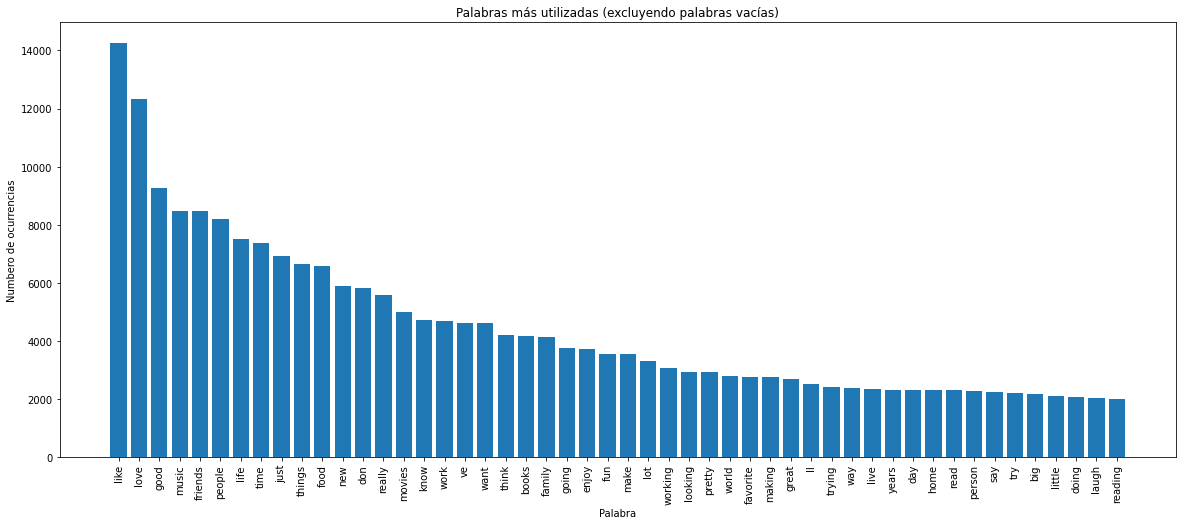

In [40]:
fig, ax = plt.subplots(figsize=(20,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Palabras más utilizadas (excluyendo palabras vacías)');
ax.set_xlabel('Palabra');
ax.set_ylabel('Numbero de ocurrencias');
plt.show()

In [41]:
tf_vectorizer = CountVectorizer(max_df=0.60, min_df=0.1,
                                stop_words='english')
tf = tf_vectorizer.fit_transform(datos[["essay"]].squeeze())

In [42]:
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=1337)
lda.fit(tf)
lda_matrix=lda.transform(tf)

In [43]:
print("Temas identificados:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Temas identificados:
Topic #0: family life food fun enjoy movies going time laugh looking
Topic #1: life things new people art time world food books enjoy
Topic #2: don just really people know things time think want ve
Topic #3: new bay san city area francisco work years ve food



Para ver cual sería el número óptimo de temas a extraer, se ha procedido a visualizar los temas asignados a las distintas personas reduciendo a 2 dimensiones con T-SNE, obteniendo las siguientes pruebas:

In [97]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=1337, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 59946 samples in 0.123s...
[t-SNE] Computed neighbors for 59946 samples in 3.897s...
[t-SNE] Computed conditional probabilities for sample 1000 / 59946
[t-SNE] Computed conditional probabilities for sample 2000 / 59946
[t-SNE] Computed conditional probabilities for sample 3000 / 59946
[t-SNE] Computed conditional probabilities for sample 4000 / 59946
[t-SNE] Computed conditional probabilities for sample 5000 / 59946
[t-SNE] Computed conditional probabilities for sample 6000 / 59946
[t-SNE] Computed conditional probabilities for sample 7000 / 59946
[t-SNE] Computed conditional probabilities for sample 8000 / 59946
[t-SNE] Computed conditional probabilities for sample 9000 / 59946
[t-SNE] Computed conditional probabilities for sample 10000 / 59946
[t-SNE] Computed conditional probabilities for sample 11000 / 59946
[t-SNE] Computed conditional probabilities for sample 12000 / 59946
[t-SNE] Computed conditional probabilities for sa

In [98]:
top_3_words_lda = get_top_n_words(3, lda_keys, tf, tf_vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_components), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_components):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)


Prueba con 10 temas:
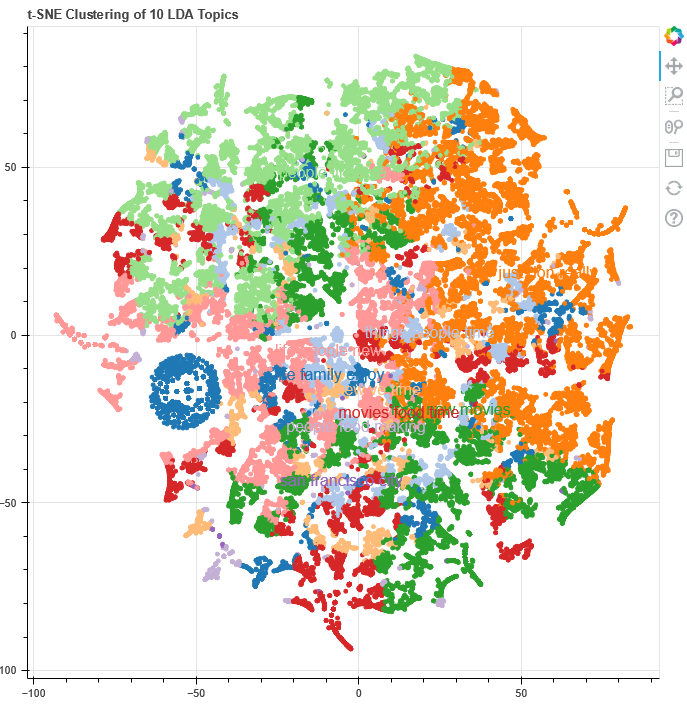
Prueba con 7 temas:
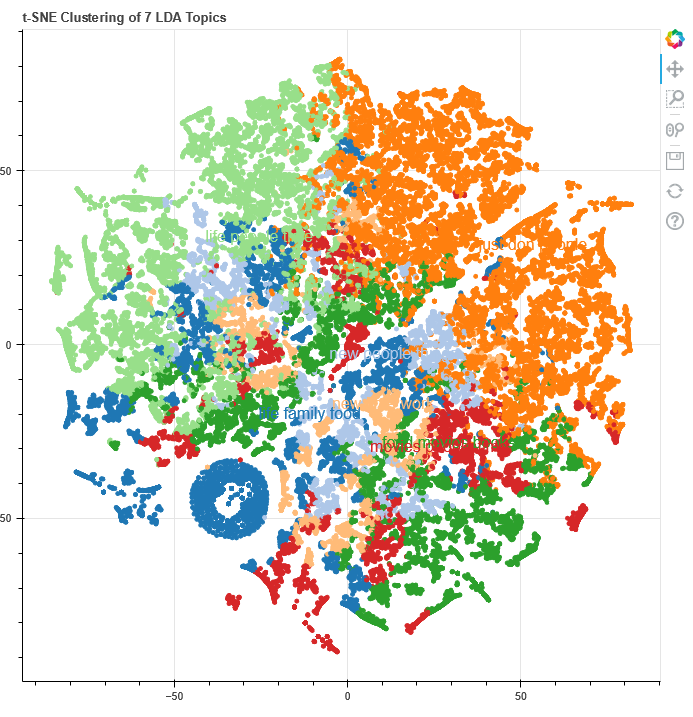
Prueba con 5 temas:
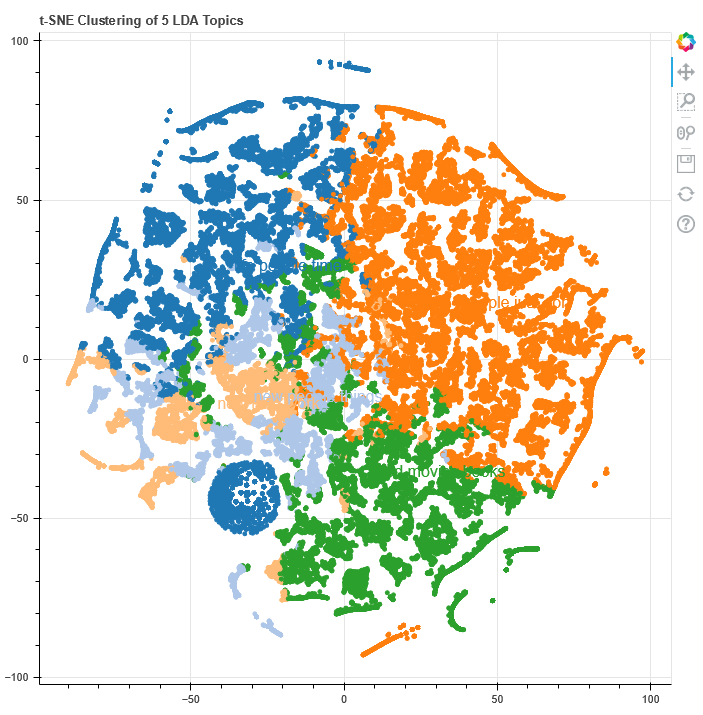
Prueba con 4 temas:
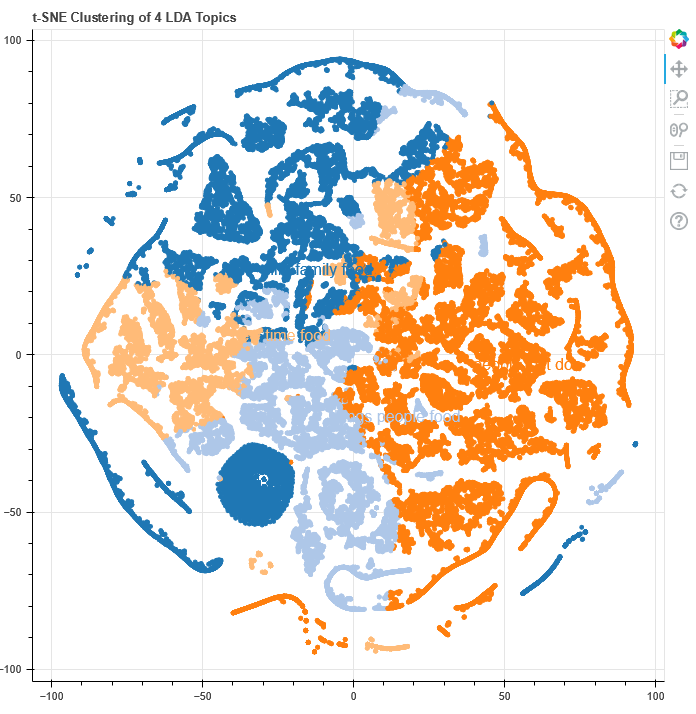
Prueba con 3 temas:
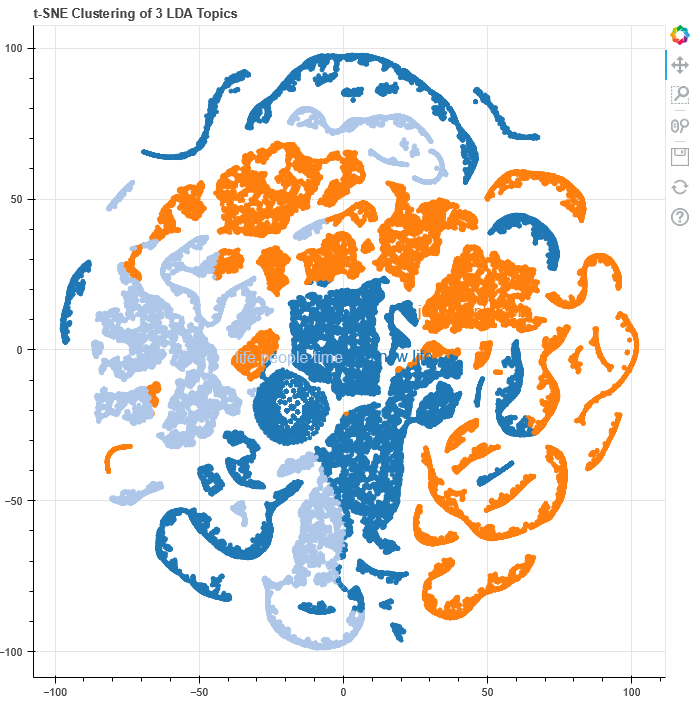

De estas pruebas podemos concluir que si extraemos más de 5 temas, éstos no quedan muy separados ni diferenciados, lo cual puede ser debido a que las personas que usan la plataforma OKCupid no responden con temas demasiado variados. Tambien podemos observar que si extraemos 3 temas, éstos quedan bien definidos y separados, pero podemos estar perdiendo información, por lo que se han considerado 4 o 5 temas como el mejor balance entre información y separación de temas. Vamos a proseguir en los siguientes pasos habiendo usado 4 temas, ya que en el de 5 temas se observa que el tema beige y el tema azul claro estan muy entremezclados y bien podría tratarse del mismo tema.

In [44]:
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_components):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = sparse.csr_matrix(temp_vector_sum)
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [45]:
lda_keys=get_keys(lda_matrix)

In [46]:
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [47]:
lda_matrix

array([[0.10231909, 0.00339856, 0.89089773, 0.00338462],
       [0.32615263, 0.00706729, 0.65977796, 0.00700212],
       [0.00267215, 0.52037467, 0.40466889, 0.07228429],
       ...,
       [0.40422051, 0.00414516, 0.00417016, 0.58746418],
       [0.1337604 , 0.07908653, 0.71906973, 0.06808333],
       [0.06429048, 0.00303166, 0.92957161, 0.00310625]])

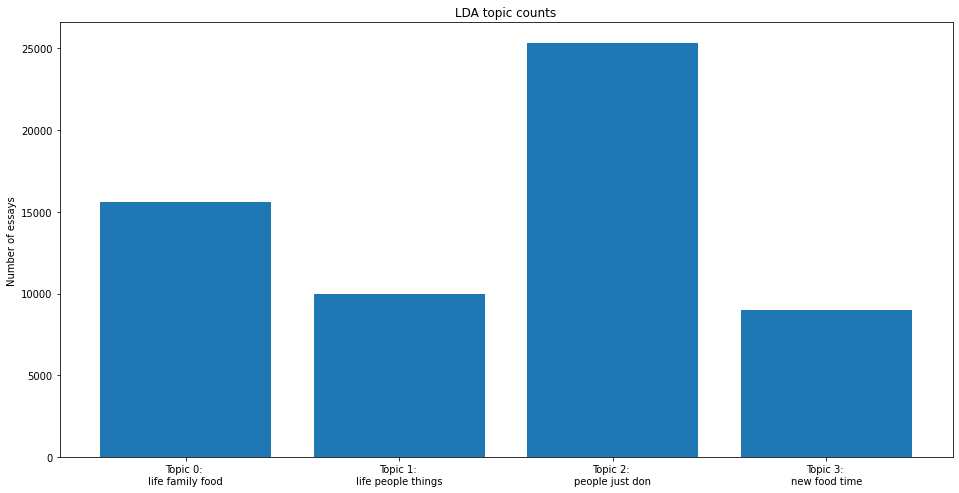

In [48]:
top_3_words = get_top_n_words(3, lda_keys, tf, tf_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA topic counts');
ax.set_ylabel('Number of essays');

Si repreentamos un histograma con el número personas a las que se les ha asignado cada tema (gráfico superior), podemos apreciar un buen reparto de temas (ningún tema poco ni demasiado asignado), por lo que podemos extraer información de este análisis.

Por último añadimos los 4 temas como 4 columnas al dataframe y le asignamos un 1 a aquellas personas que hablen de dicho tema.

In [49]:
#pasamos de los resultados de lda a columnas de dataframe para añadirlos a los datos preprocesados
for i in range(len(lda_matrix[0])):
    print("Topic"+str(i))
    datosE["Topic"+str(i)] = 0

for i in range(len(lda_matrix)):
    maxim=0
    for j in range(len(lda_matrix[i])):
        actual=lda_matrix[i][j]
        if(actual>maxim):
            maxim=actual
            Topic=j
            #print(Topic)
    datosE.at[i,"Topic"+str(Topic)] = 1        


Topic0
Topic1
Topic2
Topic3


In [50]:
datosE.iloc[:,405:]

,Topic0,Topic1,Topic2,Topic3
0,0,0,1,0
1,0,0,1,0
2,0,1,0,0
3,0,1,0,0
4,0,0,1,0
...,...,...,...,...
59941,0,1,0,0
59942,0,0,1,0
59943,0,0,0,1
59944,0,0,1,0


## 3 - Reduccion de dimensiones

Para una ejecución más eficiente de los algoritmos de clustering, vamos a proceder a reducir las dimensiones del dataframe, pues muchas de ellas no aportan apenas información como veremos a continuación.

Usando PCA y realizando un análisis de la varianza explicada podemos observar que con alrededor de 100 componentes podemos explicar mas del 90% de la varianza, por lo que podemos permitirnos esa ligera pérdida de información a cambio de reducir a menos de la mitad el número de componentes del dataframe, lo cual acelerará las operaciones.

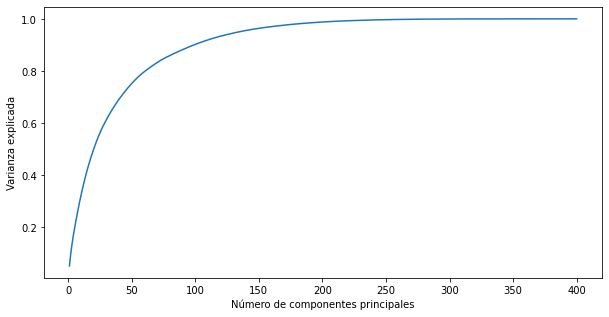

In [51]:
pca = PCA(n_components=400).fit(datosE)

plt.figure(figsize=(10,5))

xx = np.arange(1, 401, step=1)
yy = np.cumsum(pca.explained_variance_ratio_)

plt.plot(xx, yy)
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza explicada')

datos_pca = pca.transform(datosE)

In [52]:
pca = PCA(n_components=100)
datos_pca = pca.fit_transform(datosE)

## 4 - Clustering

Debido a su elevado coste computacional, el clustering se ha probado con una muestra de 5000 elementos.

In [54]:
sample = datosE.sample(n=5000, axis = 0, random_state = 1337)
pca = PCA(n_components=100)
datos_pca = pca.fit_transform(sample)

In [59]:
pca2 = PCA(n_components=2)
datosS2 = pca.fit_transform(sample)

### 4.1 - K-Means

In [70]:
n_clusters = np.arange(2,30,1)
S=[]
for n in n_clusters:
    kmeans = KMeans(n_clusters=n, n_init=1, max_iter=300, random_state=1337).fit(sample)
    labels = kmeans.labels_
    sil = silhouette_score(sample, labels)
    S.append(sil)
    print('Silhouette for ' + str(n) +' clusters: ', sil)

Silhouette for 2 clusters:  0.03471423362846606
Silhouette for 3 clusters:  0.02732327466499596
Silhouette for 4 clusters:  0.02479852281875117
Silhouette for 5 clusters:  0.027690298909075817
Silhouette for 6 clusters:  0.028057777699748817
Silhouette for 7 clusters:  0.02601041015854728
Silhouette for 8 clusters:  0.018686645052662244
Silhouette for 9 clusters:  0.019506076888389505
Silhouette for 10 clusters:  0.012677675237032648
Silhouette for 11 clusters:  0.0161008189673084
Silhouette for 12 clusters:  0.010716362314690118
Silhouette for 13 clusters:  0.024147780163554483
Silhouette for 14 clusters:  0.018561328767962265
Silhouette for 15 clusters:  0.02077415942466723
Silhouette for 16 clusters:  0.013513785005880538
Silhouette for 17 clusters:  0.00937350994161776
Silhouette for 18 clusters:  0.01537026381768609
Silhouette for 19 clusters:  0.011356940991761665
Silhouette for 20 clusters:  0.011533135142468606
Silhouette for 21 clusters:  0.012020496570955018
Silhouette for 22

In [91]:
kmeans = KMeans(n_clusters=13, n_init=1, max_iter=300, random_state=1337)
kmeans.fit(datos_pca)
labels = kmeans.labels_

In [94]:
pca2 = PCA(n_components=2)
datos2 = pca.fit_transform(sample)

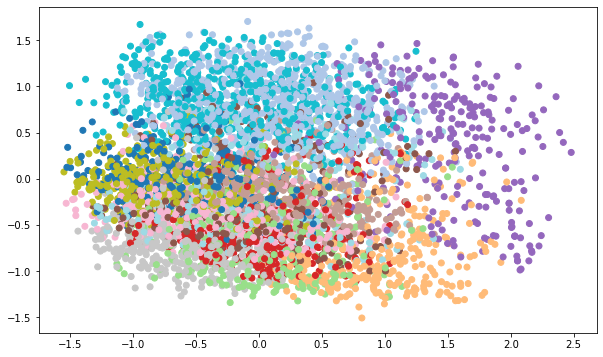

In [95]:
#Dibujamos el mejor resultado
plt.figure(figsize=(10,6))
plt.scatter(datos2[:,0], datos2[:,1], c=labels.astype(float), cmap='tab20')

### 4.2 - DBSCAN

In [67]:
dbscan_pca = DBSCAN(eps=3, min_samples=2).fit(datos_pca)

In [70]:
labels_pca = dbscan_pca.labels_
dbscan_pca.n_features_in_

400

In [75]:
nclusters_pca = len(set(labels_pca)) - (1 if -1 in labels_pca else 0)
nclusters_pca

202

In [81]:
eps = [0.5,3,10]
min_samples = [2,5]
for e in eps:
    for m in min_samples:
        dbscan_pca = DBSCAN(eps=3, min_samples=2).fit(datos_pca)
        labels = dbscan_pca.labels_
        print('Silhouette for eps =' + str(e) +', min_samples= '+str(m) +': ', silhouette_score(datos_pca, labels))
        print('Clusters = ' + str(len(set(labels_pca)) - (1 if -1 in labels_pca else 0)))

Silhouette for eps =0.5, min_samples= 2:  -0.13050614280430034
Clusters = 202
Silhouette for eps =0.5, min_samples= 5:  -0.13050614280430034
Clusters = 202
Silhouette for eps =3, min_samples= 2:  -0.13050614280430034
Clusters = 202
Silhouette for eps =3, min_samples= 5:  -0.13050614280430034
Clusters = 202
Silhouette for eps =10, min_samples= 2:  -0.13050614280430034
Clusters = 202
Silhouette for eps =10, min_samples= 5:  -0.13050614280430034
Clusters = 202


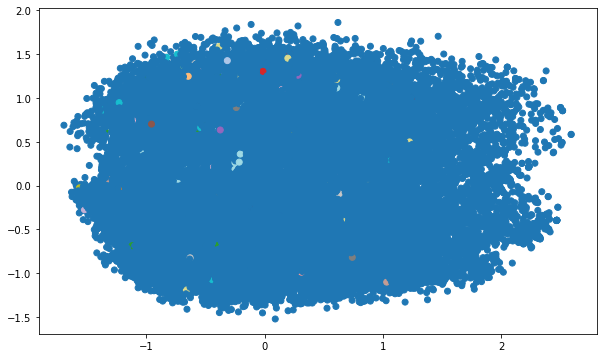

In [74]:
#Dibujamos el mejor resultado
plt.figure(figsize=(10,6))
plt.scatter(datos2[:,0], datos2[:,1], c=labels_pca.astype(float), cmap='tab20')

### 4.3 - Clustering jerárquico

In [62]:
AC = AgglomerativeClustering(n_clusters=7, affinity='cosine', linkage='single').fit(sample)

In [81]:
SCJ = []
for n in n_clusters:
    AC = AgglomerativeClustering(n_clusters=n, affinity='cosine', linkage='single').fit(sample)
    labels = AC.labels_
    sil = silhouette_score(sample, labels)
    SCJ.append(sil)
    print('Silhouette for ' + str(n) +' clusters: ', sil)

Silhouette for 2 clusters:  0.10787135644273162
Silhouette for 3 clusters:  0.08708063368366081
Silhouette for 4 clusters:  0.0799456961522907
Silhouette for 5 clusters:  0.07473133721193141
Silhouette for 6 clusters:  0.07132225758674057
Silhouette for 7 clusters:  0.07011331200381084
Silhouette for 8 clusters:  0.06535586989361722
Silhouette for 9 clusters:  0.06326461198331074
Silhouette for 10 clusters:  0.053579605321647385
Silhouette for 11 clusters:  0.051753131626807364
Silhouette for 12 clusters:  0.0506545782754348
Silhouette for 13 clusters:  0.0480099521622182
Silhouette for 14 clusters:  0.04495897160336608
Silhouette for 15 clusters:  0.036033463774877234
Silhouette for 16 clusters:  0.03528443622164284
Silhouette for 17 clusters:  0.03476772582074335
Silhouette for 18 clusters:  0.032641058627692746
Silhouette for 19 clusters:  0.02855962763301623
Silhouette for 20 clusters:  0.026963197359847743
Silhouette for 21 clusters:  0.024216776983868506
Silhouette for 22 cluster

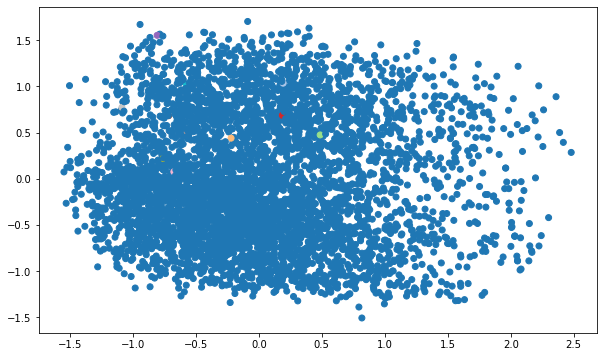

In [98]:
#Dibujamos 13 clusters para comparar con K-Means
AC = AgglomerativeClustering(n_clusters=13, affinity='cosine', linkage='single').fit(sample)
labels = AC.labels_
plt.figure(figsize=(10,6))
plt.scatter(datosS2[:,0], datosS2[:,1], c=labels.astype(float), cmap='tab20')

### 4.4 - Clustering Espectral

In [78]:
SCE = SpectralClustering(n_clusters=7, affinity='nearest_neighbors', random_state = 1337).fit(sample)
silhouette_score(sample, labels)

0.01574796415533762

In [77]:
for n in n_clusters:
    SCE = SpectralClustering(n_clusters=n, affinity='nearest_neighbors', random_state = 1337).fit(sample)
    labels = SPC.labels_
    sil = silhouette_score(sample, labels)
    SCE.append(sil)
    print('Silhouette for ' + str(n) +' clusters: ', sil)

Silhouette for 2 clusters:  0.01574796415533762
Silhouette for 3 clusters:  0.01574796415533762
Silhouette for 4 clusters:  0.01574796415533762
Silhouette for 5 clusters:  0.01574796415533762
Silhouette for 6 clusters:  0.01574796415533762
Silhouette for 7 clusters:  0.01574796415533762
Silhouette for 8 clusters:  0.01574796415533762
Silhouette for 9 clusters:  0.01574796415533762


KeyboardInterrupt: 

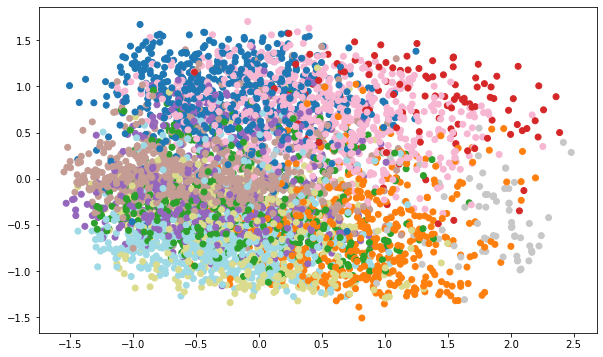

In [82]:
#Dibujamos el mejor resultado
SPC = SpectralClustering(n_clusters=10, affinity='nearest_neighbors', random_state = 1337).fit(sample)
labels = SPC.labels_
plt.figure(figsize=(10,6))
plt.scatter(datosS2[:,0], datosS2[:,1], c=labels.astype(float), cmap='tab20')

## 5 - Comparativa y conclusiones

Despues de probar los 4 modelos vistos en el apartado anterior, no se ha conseguido llegar a una configuaración satisfactoria de DBSCAN ni de Spectral Clustering, pero si de K-Means y Clustering Jerárquico.

In [89]:
#Simulación de los resultados de Spectral Clustering
SCE = []
for i in range(28):
    SCE.append(0.01574796415533762)

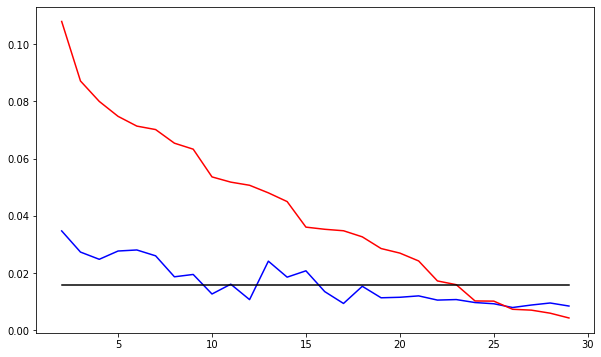

In [90]:
plt.figure(figsize=(10,6))
plt.plot(n_clusters,S, c = 'blue')
plt.plot(n_clusters,SCJ, c = 'red')
plt.plot(n_clusters,SCE, c= 'black')

Comparando las 3 variaciones del coeficiente silhouette podemos observar que K-Means tiene un máximo local en 13 clusters por lo que parece el número de clusters óptimo para este algoritmo ya que los puntos con mayor coeficiente que hay con menos cantidad de clusters no son mucho más elevado y aportan una menor division del conjunto de datos.

Sin embargo, parece que el Cluster Jerárquico (rojo) parece una mejor opción que K-Means ya que por el mismo número de clusters obtenemos un mayor coeficiente de silhouette y aun podríamos aumentar más el número de clusters y dicho coeficiente seguiría superando al de K-Means, por lo que podría considerarse mejor, pero si nos fijamos en su representación, parece que no ha elegido muy buenos clusters, siendo muchos de 1 solo elemento, por lo que K-Means parece ser la mejor opcion con lo que se ha conseguido.

Video explicativo : https://drive.google.com/file/d/1KDohAvCSG0NHgY9JlfTddLx-sDZPEF7r/view?usp=sharing

Francisco Javier Burgos Banegas - Grupo 25